# Task 3.3 Transpile and Optimize Circuits

**Overview:** This notebook covers how Qiskit transpiles and optimizes circuits.

*   **Transpiler stages** and what is performaed in each of them.
*   **Pass managers** , staged pass managers and preset pass managers.
*   **Transpiler passes** in pass managers.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit,QuantumRegister
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.circuit.library import HGate, PhaseGate, RXGate, TdgGate, TGate
from qiskit_ibm_runtime.fake_provider import FakeAuckland,FakeTorino, FakeWashingtonV2
from qiskit.visualization import plot_circuit_layout
from qiskit.transpiler import generate_preset_pass_manager,PassManager, StagedPassManager
from qiskit.transpiler.passes import InverseCancellation
from qiskit.transpiler.passes import UnitarySynthesis, Unroll3qOrMore
from qiskit.transpiler.passes import (
    Collect2qBlocks,
    ConsolidateBlocks,
    UnitarySynthesis,
)

print("Libraries imported successfully.")

Libraries imported successfully.


## Objective 1 : Transpiler stages

Transpilation is the process of transforming quantum circuits to make them executable on real quantum hardware. This involves:
- Mapping logical qubits to physical qubits.
- Adding SWAP gates to satisfy connectivity constraints.
- Converting gates to hardware-native basis gates.
- Optimizing circuit depth and gate count.
- Scheduling operations to minimize idle time.

### **The Transpiler Stages**

Qiskit's transpiler processes circuits through these stages:
1. **Initialization** - Custom optimizations and multi-qubit gate decomposition
2. **Layout** - Virtual to physical qubit mapping
3. **Routing** - SWAP gate insertion for connectivity
4. **Translation** - Gate conversion to hardware basis
5. **Optimization** - Circuit depth and gate count reduction
6. **Scheduling** - Timing and delay insertion

### 1. Initialization Stage

The initialization stage prepares the circuit for transpilation by:
- Applying custom optimizations.
- Decomposing multi-qubit gates (>2 qubits) into one and two-qubit gates.
- Setting up the circuit for subsequent stages.

### 2. Layout Stage


The layout stage maps virtual qubits to physical qubits on the target backend with the goal of minimizing the number of required SWAP gates. Different layout strategies are:

- **TrivialLayout**: Simple sequential mapping (qubit 0→0, 1→1, etc.)
- **VF2Layout**: Uses subgraph isomorphism to find optimal mappings.
- **DenseLayout**: Finds the most connected qubit subset.
- **SabreLayout**: Uses iterative bidirectional routing.
- **CSPLayout**: Constraint satisfaction problem approach.

### 3. Routing Stage

The routing stage inserts SWAP gates to make the circuit executable on the hardware's connectivity graph. this stage is typically computed alongside the Layout stage by default, but they are logically distinct from one another.

Different Routing Methods:
- **SabreSwap**: Most commonly used, heuristic-based routing.
- **BasicSwap**: Simple but less efficient.
- **LookaheadSwap**: More sophisticated but computationally expensive.

Trivial Layout Depths: Mean=65.76, Min=63, Max=69


Text(0, 0.5, 'Counts')

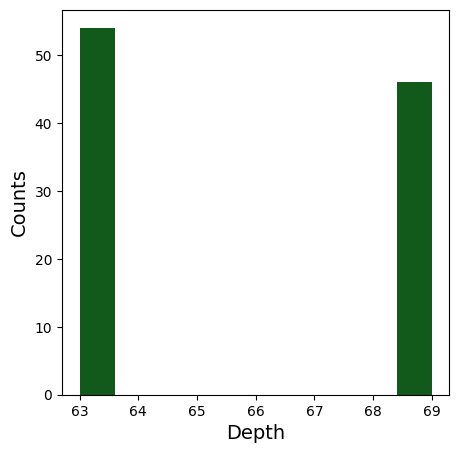

In [2]:
backend = FakeAuckland()
 
ghz = QuantumCircuit(20)
ghz.h(0)
ghz.cx(0, range(1, 15))
 
depths = []
for seed in range(100):
    pass_manager = generate_preset_pass_manager(
        optimization_level=1,
        backend=backend,
        layout_method="trivial",  # Fixed layout mapped in circuit order
        seed_transpiler=seed,  # For reproducible results
    )
    depths.append(pass_manager.run(ghz).depth())

print(f"Trivial Layout Depths: Mean={sum(depths)/len(depths):.2f}, Min={min(depths)}, Max={max(depths)}")
 
plt.figure(figsize=(5, 5))
plt.hist(depths, color=["#115A1C"])
plt.xlabel("Depth", fontsize=14)
plt.ylabel("Counts", fontsize=14)

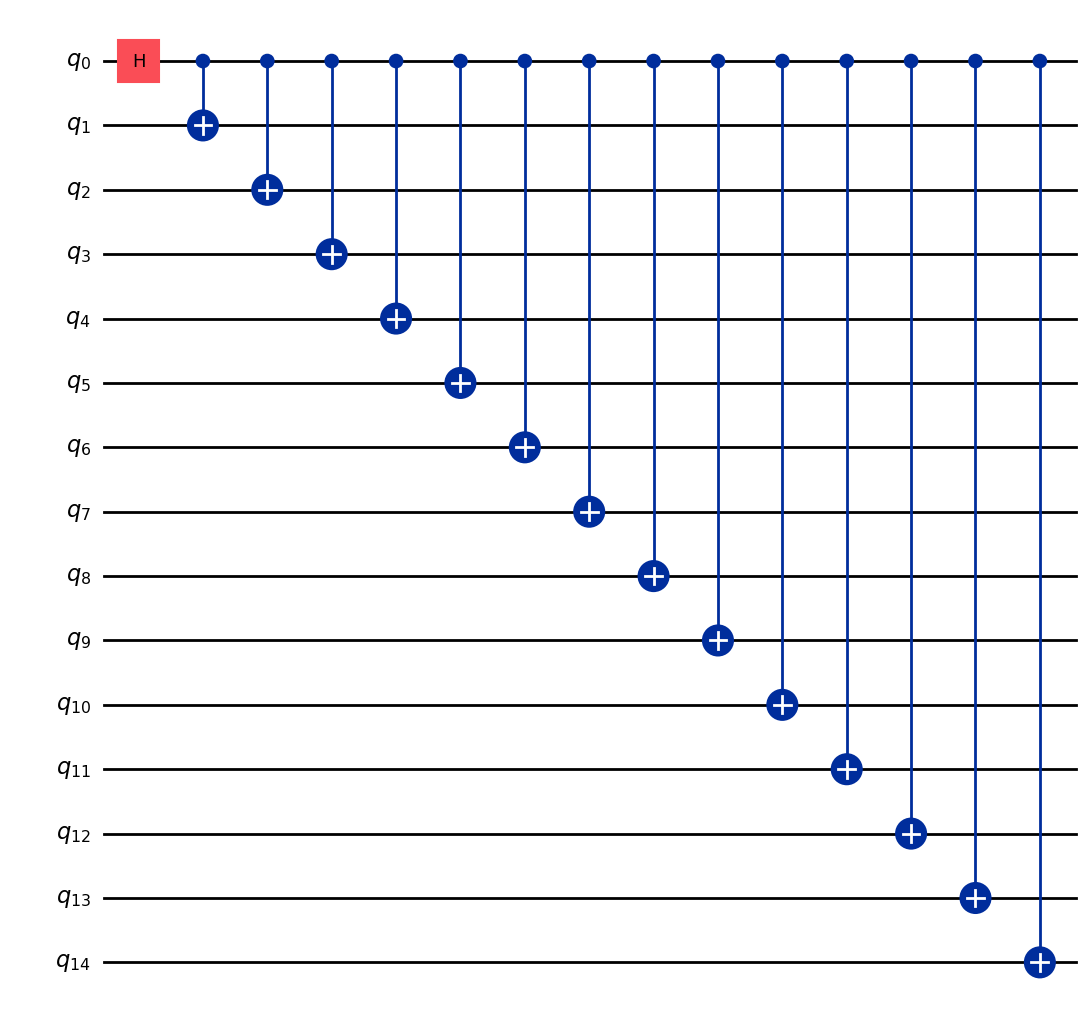

In [3]:
ghz.draw("mpl", idle_wires=False)

Original GHZ circuit has 20 qubits with depth 15
Transpiled GHZ circuit has 27 qubits with depth 69


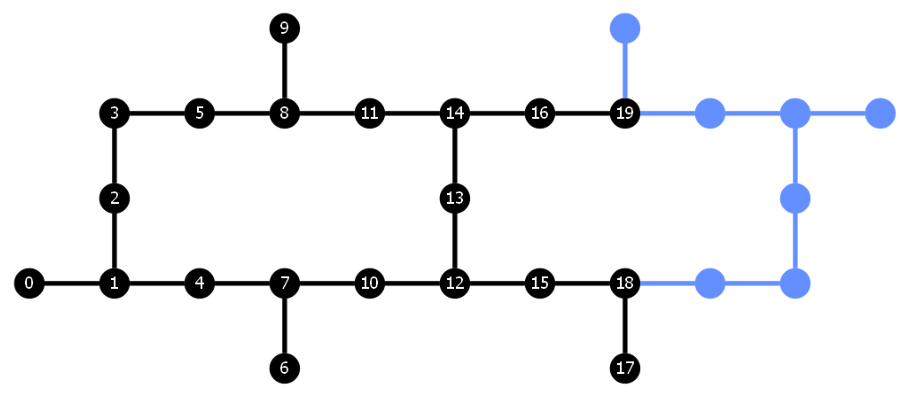

In [4]:
# Show original circuit properties
print(f"Original GHZ circuit has {ghz.num_qubits} qubits with depth {ghz.depth()}")

# Plot the hardware graph and indicate which hardware qubits were chosen to run the circuit
transpiled_circ = pass_manager.run(ghz)

# Show transpiled circuit properties
print(f"Transpiled GHZ circuit has {transpiled_circ.num_qubits} qubits with depth {transpiled_circ.depth()}")

# - plot_circuit_layout() shows how virtual qubits map to physical qubits
plot_circuit_layout(transpiled_circ, backend)

### **4. Translation Stage**


The translation stage converts all gates in the circuit to the hardware's native basis gates. This stage allows the circuit to be executed at the backend, but it leads to increase in the circuit depth and number of gates.

IBM quantum computers support:
- Single-qubit gates: `['id', 'rz', 'sx', 'x']`
- Two-qubit gates: `['cx', 'ecr']`

**Translation Passes**: 
- BasisTranslator:searches a library for a set of translations over basis set.
- Decompose: expand gates in circuits using its decomposition rules.
- Unroll3qOrMore: expand 3 qubits + gates until the circuit contains 1 or 2 qubits gates only.

native gates:['cx', 'delay', 'for_loop', 'id', 'if_else', 'measure', 'reset', 'rz', 'switch_case', 'sx', 'x']


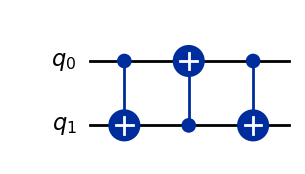

In [5]:
# Show native gates supported by the backend
print("native gates:" + str(sorted(backend.operation_names)))
# SWAP gate is translated to 3 CNOT gates
qc = QuantumCircuit(2)
qc.swap(0, 1)
qc.decompose().draw("mpl")

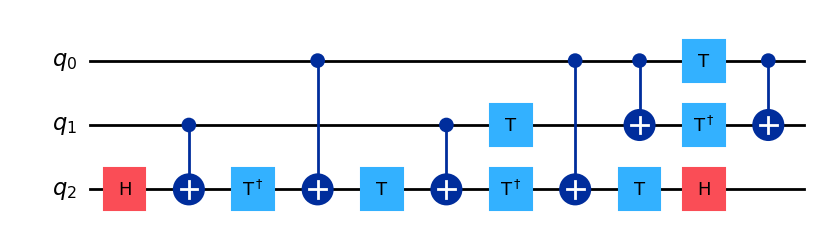

In [6]:
# a Toffoli gate is translated to multiple CNOT and single qubit gates 
qc = QuantumCircuit(3)
qc.ccx(0, 1, 2)
qc.decompose().draw("mpl")

### **5. Optimization Stage**

The optimization stage reduces circuit depth and gate count through various techniques.

**Optimization Levels**:
- Level 0: No optimization
- Level 1: (Optimize1qGatesDecomposition, CXCancellation)
- Level 2: (+ CommutativeCancellation)
- Level 3: (+ Collect2qBlocks, ConsolidateBlocks, UnitarySynthesis, Optimize1qGateDecomposition, CommutativeCancellation)

It also does final checks to make sure all instructions are composed of the basis gates on the backend.

**Optimization Passes**:
- CXCancellation : Remove consecutive CX gates that cancel out.
- CommutativeCancellation: Cancel gates that commute and are inverses.
- Optimize1qGates: Combine consecutive single-qubit gates.

Level 0: Depth=73, Total Gates=101, CX Gates=98
Level 1: Depth=47, Total Gates=47, CX Gates=44
Level 2: Depth=43, Total Gates=53, CX Gates=40
Level 3: Depth=44, Total Gates=48, CX Gates=35


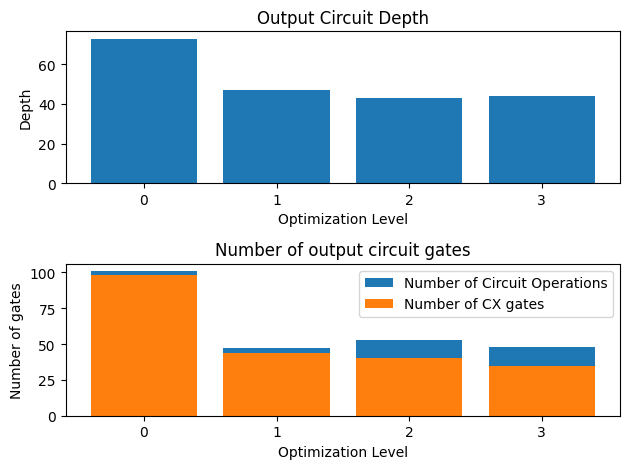

In [5]:
# Compare different optimization levels
ghz = QuantumCircuit(15)
ghz.h(0)
ghz.cx(0, range(1, 15))
 
depths = []
gate_counts = []
multiqubit_gate_counts = []
levels = [str(x) for x in range(4)]
# try optimiaztion level 0,1,2,3
for level in range(4):
    pass_manager = generate_preset_pass_manager(
        optimization_level=level,
        backend=backend,
        seed_transpiler=111,
    )
    circ = pass_manager.run(ghz)
    depths.append(circ.depth())
    gate_counts.append(sum(circ.count_ops().values()))
    multiqubit_gate_counts.append(circ.count_ops()["cx"])
    print(f"Level {level}: Depth={circ.depth()}, Total Gates={sum(circ.count_ops().values())}, CX Gates={circ.count_ops().get('cx', 0)}")

fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.bar(levels, depths, label="Depth")
ax1.set_xlabel("Optimization Level")
ax1.set_ylabel("Depth")
ax1.set_title("Output Circuit Depth")
ax2.bar(levels, gate_counts, label="Number of Circuit Operations")
ax2.bar(levels, multiqubit_gate_counts, label="Number of CX gates")
ax2.set_xlabel("Optimization Level")
ax2.set_ylabel("Number of gates")
ax2.legend()
ax2.set_title("Number of output circuit gates")
fig.tight_layout()
plt.show()

### **6. Scheduling Stage**

The scheduling stage must be explicitly called, it mainly adds timing information and accounts for idle times in the circuit.
it involves 2 parts analysis and constraint mapping 

**Analysis Scheduling Methods**:
- ASAPSchedulingAnalysis: Schedule gates as soon as possible
- ALAPSchedulingAnalysis: Schedule gates as late as possible

**Constraints Passes**:
- ConstrainedReschedule: update node start time to account for target hardware alignments 

Scheduled circuit depth: 17
Circuit contains Delay instructions: True


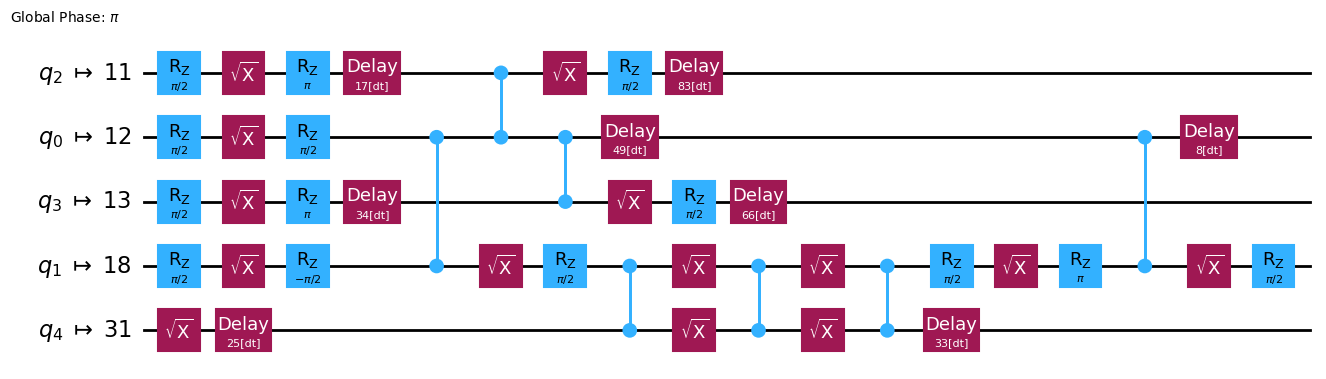

In [6]:
# Create a smaller GHZ circuit for scheduling demonstration
ghz = QuantumCircuit(5)
ghz.h(0)
ghz.cx(0, range(1, 5))
 
 
# Use fake backend
backend = FakeTorino()
 
# Run with optimization level 3 and 'asap' or 'alap' scheduling pass
pass_manager = generate_preset_pass_manager(
    optimization_level=3,
    backend=backend,
    scheduling_method="asap",
    #scheduling_method="alap",
    seed_transpiler=111,
)
 
 
circ = pass_manager.run(ghz)
print(f"Scheduled circuit depth: {circ.depth()}")
print(f"Circuit contains Delay instructions: {'delay' in circ.count_ops()}")
circ.draw(output="mpl", idle_wires=False)

## Objective 2: Transpile with Pass Managers

- A Pass Manager is an object that stores all transpiler passes and executes them when its ```run()``` method is called.
- A Staged Pass Manager is a higher-level abstraction on top of the pass manager, it is composed of a several pass managers.
- generate_preset_pass_manager() creates a pre-configured pass manager with commonly used passes.

The example below creates a preset pass managers with optimiaztion level 3, It then prints the depth and number of gates after the pass manager runs.

In [8]:
service = QiskitRuntimeService()
# use a backend that is in your account
backend = service.backend("ibm_torino")
pass_manager = generate_preset_pass_manager(
    optimization_level=3, backend=backend
)

In [9]:
 # Create a circuit
qubits = QuantumRegister(2, name="q")
circuit = QuantumCircuit(qubits)
a, b = qubits
circuit.h(a)
circuit.cx(a, b)
circuit.cx(b, a) # This should cancel with the previous CX

# Transpile it by calling the run method of the pass manager
transpiled = pass_manager.run(circuit) 

print(f"Transpiled circuit with optimization level 3 depth: {transpiled.depth()}")
print(f"Transpiled circuit with no optimization level 3 gates: {transpiled.count_ops()}")

Transpiled circuit with optimization level 3 depth: 9
Transpiled circuit with no optimization level 3 gates: OrderedDict({'rz': 7, 'sx': 5, 'cz': 2})


This example creates a custom translation pass manager, After that it tests it on a circuit and prints the circuit before and after the pass manager is run.

In [10]:
# Create a custom translation pass manager
basis_gates = ["rx", "ry", "rxx"]
translation_pass_manager = PassManager(
    [
        Collect2qBlocks(),
        ConsolidateBlocks(basis_gates=basis_gates),
        UnitarySynthesis(basis_gates),
    ]
)

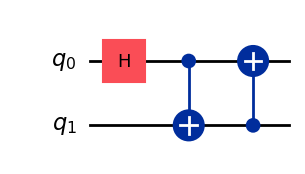

In [11]:
qubits = QuantumRegister(2, name="q")
circuit = QuantumCircuit(qubits)
 
# Apply custom translation
a, b = qubits
circuit.h(a)
circuit.cx(a, b)
circuit.cx(b, a)
 
circuit.draw("mpl")

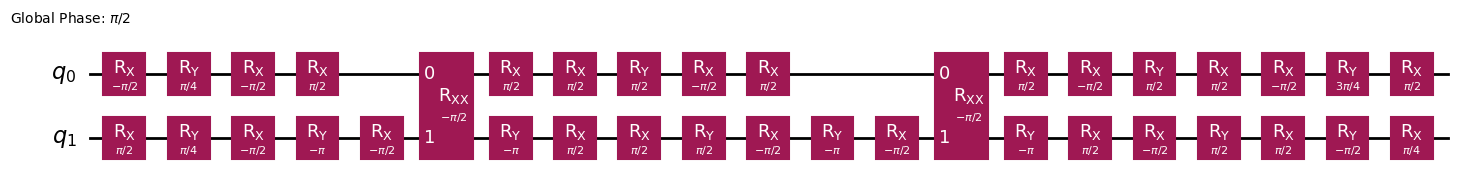

In [12]:
translated = translation_pass_manager.run(circuit)
translated.draw("mpl")

The next example is for a staged pass manager , it can have multiple stages and each stage is defined by its own pass manager.

In [13]:
basis_gates = ["rx", "ry", "rxx"]
init_pass_manager = PassManager(
    [UnitarySynthesis(basis_gates, min_qubits=3), Unroll3qOrMore()]
)
# Create staged pass manager with init and translation stages
# Pass Managers init_pass_manager and translation_pass_manager
staged_pm = StagedPassManager(
    stages=["init", "translation"], init=init_pass_manager, translation=translation_pass_manager
)
print(f"Staged pass manager successfully created with stages: {staged_pm.stages}")

Staged pass manager successfully created with stages: ('init', 'translation')


Another Option is to use a preset pass manager and then change some of its stages. The example below adds a pre_layout stage 

In [14]:
# Create a custom optimization pass 
pass_manager = generate_preset_pass_manager(3, backend)
# Define gates that cancel when they appear as inverses
inverse_gate_list = [
    HGate(),
    (RXGate(np.pi / 4), RXGate(-np.pi / 4)),
    (PhaseGate(np.pi / 4), PhaseGate(-np.pi / 4)),
    (TGate(), TdgGate()),
]

# Create logical optimization pass manager
logical_opt = PassManager(
    [
        InverseCancellation(inverse_gate_list),
    ]
)
 
# Add custom optimization to pre-layout stage
pass_manager.pre_layout = logical_opt
print("Custom inverse cancellation pass added to pre-layout stage")

Custom inverse cancellation pass added to pre-layout stage


## Objective 3 Transpiler Passes

### Layout



- **TrivialLayout**: Choose a Layout by assigning n circuit qubits to device qubits 0, .., n-1.
- **DenseLayout**: Choose a Layout by finding the most connected subset of qubits.
- **SabreLayout**: Choose a Layout via iterative bidirectional routing of the input circuit.
- **CSPLayout**: If possible, chooses a Layout as a CSP, using backtracking.
- **VF2Layout**: A pass for choosing a Layout of a circuit onto a Coupling graph, as a subgraph isomorphism problem, solved by VF2++.

### Routing


- **BasicSwap**: Map (with minimum effort) a DAGCircuit onto a coupling_map adding swap gates.
- **Commuting2qGateRouter**: Swap route one or more commuting gates to the coupling map.
- **LayoutTransformation**: Adds a Swap circuit for a given (partial) permutation to the circuit.
- **LookaheadSwap**: Map input circuit onto a backend topology via insertion of SWAPs.
- **SabreSwap**: Map input circuit onto a backend topology via insertion of SWAPs.
- **StarPreRouting**: run star to lineat pre-routing


### Basis Change



- **BasisTranslator**: Translates gates to a target basis by searching for a set of translations from a given EquivalenceLibrary.
- **Decompose**: Expand a gate in a circuit using its decomposition rules.
- **TranslateParameterizedGates**: Translate parameterized gates to a supported basis set.
- **Unroll3qOrMore**: Recursively expands 3q+ gates until the circuit only contains 2q or 1q gates.
- **UnrollCustomDefinitions**: Unrolls instructions with custom definitions.

### Optimization



- **Collect1qRuns**: Collect one-qubit subcircuits.
- **Collect2qBlocks**: Collect two-qubit subcircuits.
- **CommutativeCancellation**: Cancel the redundant (self-adjoint) gates through commutation relations.
- **ConsolidateBlocks**: Replace each block of consecutive gates by a single Unitary node.
- **InverseCancellation**: Cancel specific Gates which are inverses of each other when they occur back-to- back.
- **Optimize1qGates**: Optimize chains of single-qubit u1, u2, u3 gates by combining them into a single gate.
- **Optimize1qGatesDecomposition**: Optimize chains of single-qubit gates by combining them into a single gate.
- **Optimize1qGatesSimpleCommutation**: Optimizes 1Q gate strings interrupted by 2Q gates by commuting the components and resynthesizing the results.

### Scheduling

- **ALAPScheduleAnalysis**: ALAP Scheduling pass, which schedules the stop time of instructions as late as possible.
- **ASAPScheduleAnalysis**: ASAP Scheduling pass, which schedules the start time of instructions as early as possible.
- **ConstrainedReschedule**: Rescheduler pass that updates node start times to conform to the hardware alignments.
- **ContextAwareDynamicalDecoupling**: Implement an X-sequence dynamical decoupling considering the gate- and qubit-context.
- **InstructionDurationCheck**: Duration validation pass for reschedule.
- **PadDelay**: Padding idle time with Delay instructions.
- **PadDynamicalDecoupling**: Dynamical decoupling insertion pass.
- **SetIOLatency**: Set IOLatency information to the input circuit.
- **TimeUnitConversion**: Choose a time unit to be used in the following time-aware passes, and make all circuit time units consistent with that.


Besides the five transpiler passes mentioned above, Qiskit provides many additional passes such as circuit analysis, synthesis, post-layout, and others. You can find the full list of available transpiler passes here https://quantum.cloud.ibm.com/docs/en/api/qiskit/transpiler_passes

---
# Summary
---

In this notebook, we covered:

## Transpile circuits:

1. **Transpiler stages** are steps that are taken to to transfrom quantum circuits to be executable on a specfic hardware.
    * Initialization: Prepares the circuit by applying custom optimizations and decomposing multi-qubit gates into 1- and 2-qubit gates.
    * Layout: Maps the circuit's logical (virtual) qubits to the backend's physical qubits.
    * Routing: Inserts SWAP gates to satisfy the hardware's connectivity constraints after qubit mapping.
    * Translation: Converts all gates in the circuit to the hardware's native basis gates.
    * Optimization: Reduces circuit depth and gate count.
    * Scheduling: Adds timing information, accounts for idle times, and inserts delays.
2. **Pass managers** are used to manage and execute sequences of transpiler passes , you can use PassManager, StagedPassManager or generate_preset_pass_manager()
3. **Transpiler passes** are the steps taken in a pass manager to transform a circuit to run on a specfic quantum device. they are split in to 5 main passes but there are others that can be included in custom pass managers.


---

## Practice Questions

**1) Which sequence correctly lists four main transpiler stages in Qiskit’s pipeline?**

A) Initilization → Optimization → Scheduling → Circuit Analysis

B) Pre-Layout → Layout → Post-Layout → Optimization

C) Layout → Routing → Transformation → Optimization → Scheduling

D) Parsing →  Compilation → Simulation → Execution

E) Layout → Routing → Optimization → Scheduling


***Answer:***
<Details>
<br/>
The correct sequence is 
E) Layout → Routing → Optimization → Scheduling 
</Details>

---

**2) In the following code below, What does the ```Unroll3qOrMore``` pass do?**


```
from qiskit.transpiler.passes import Unroll3qOrMore
pm = PassManager([Unroll3qOrMore()])
tc = pm.run(qc)
```

A) Replaces measurements with classical registers

B) Converts all gates into 3-qubit or higher equivalents

C) Breaks multi-qubit gates into supported 1- and 2-qubit basis gates

D) Optimizes circuits by merging rotations


***Answer:***
<Details>
<br/>
 
C) Breaks multi-qubit gates into supported 1- and 2-qubit basis gates
 
</Details>